In [1]:
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, r2_score, classification_report

from keras import Model, Sequential
from keras import metrics
from keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

In [2]:
# carregar os dados de entrada
inputs_file = 'input_db_29_08_2023_14_26_20.pkl'
with open(inputs_file, 'rb') as handle_inputs:
    inputs = pickle.load(handle_inputs)

In [3]:
inputs.head()

,site_lat,site_long,sat_long,freq,eirp,hsat,bw_total,bw_util,rolloff,mod,fec,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,35786,36,16.155547,0.2,32APSK,126/180,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,35786,36,22.226415,0.2,32APSK,135/180,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518
2,-19.167619,-34.986496,-2.622435,5.349325,56.252903,35786,36,35.827805,0.2,64APSK,162/180,19.590329,1.207189,0.530488,57.036432,28.600282,5.894995,1.506105
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,35786,36,14.203504,0.2,8PSK,100/180,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,35786,36,9.488156,0.2,32APSK,126/180,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052


In [4]:
inputs = inputs.drop(columns=["hsat", "bw_total", "mod", "fec", "rolloff"])

In [5]:
# carregar os dados de saída - 
# apenas a coluna availability é relevante para o problema, 
# pode-se ignorar as demais para o treinamento e teste
results_file = 'results_db_29_08_2023_14_26_20.pkl'
with open(results_file, 'rb') as handle_results:
    results = pickle.load(handle_results)

In [6]:
results.head()

,availability,a_fs,a_g,a_c,a_r,a_s,a_t,a_tot,a_depoint,c_n0,...,earth_radius,elevation_angle,distance,fig_merit,noise_ground,noise_sky,ant_noise,noise_total,ant_gain,ant_3db
0,99.904,207.841452,0.322924,0.966845,9.079432,0.526741,10.383000,220.241483,2.017030,84.759447,...,6367.489544,43.741256,37499.215397,24.276649,10.0,10.860506,260.815713,286.308799,43.398944,1.263074
1,99.999,201.903879,0.065287,0.201974,7.102761,0.439884,7.383255,277.812514,68.525380,112.688241,...,6367.489544,56.474767,36698.322584,95.134206,10.0,3.208548,235.351027,248.680367,46.873483,0.591097
2,96.460,198.393586,0.065097,0.039061,0.016178,0.116006,0.193583,201.164695,2.577525,-99916.332614,...,6367.489544,47.007765,37271.796260,-100000.000000,10.0,3.867110,25.687222,54.289160,33.854824,3.249709
3,99.999,206.567603,0.201870,0.712902,27.381892,0.930295,28.312062,241.951596,7.071931,86.145051,...,6367.489544,59.412644,36547.299501,23.855004,10.0,5.183472,284.602019,314.728183,39.509835,1.408672
4,99.990,207.986262,0.381950,1.032110,16.817812,0.716087,18.246230,232.308445,6.075953,82.544269,...,6367.489544,37.330831,37986.968867,26.033504,10.0,12.583786,281.070225,302.118263,43.249134,0.517240


In [7]:
# preprocessamento da base de dados - 
# as linhas cuja coluna fig_merit têm valor igual a -100000 
# são casos inválidos e devem ser removidos 
filter_matrix = results.fig_merit != -100000
print(filter_matrix.head())
print(np.sum(filter_matrix))

0     True
1     True
2    False
3     True
4     True
Name: fig_merit, dtype: bool
1457619


In [8]:
filtered_inputs = inputs[filter_matrix]
filtered_results = results[filter_matrix]

In [9]:
print(filtered_inputs.shape)
print(inputs.shape)

print(filtered_results.shape)
print(results.shape)

(1457619, 13)
(1880000, 13)
(1457619, 21)
(1880000, 21)


           site_lat     site_long      sat_long          freq          eirp  \
count  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean  -1.505471e+01 -5.330440e+01 -5.230916e+01  1.132981e+01  5.091215e+01   
std    1.061157e+01  1.080609e+01  3.258509e+01  4.041949e+00  1.763086e+01   
min   -3.368997e+01 -7.288998e+01 -1.079999e+02  3.000049e+00  1.500033e+01   
25%   -2.430390e+01 -6.240066e+01 -8.093161e+01  7.965716e+00  3.691857e+01   
50%   -1.470179e+01 -5.317498e+01 -5.223987e+01  1.150008e+01  5.183633e+01   
75%   -5.817384e+00 -4.398199e+01 -2.366515e+01  1.483480e+01  6.597661e+01   
max    2.819986e+00 -3.480004e+01  2.999920e+00  1.799999e+01  7.999994e+01   

            bw_util  snr_threshold      ant_size       ant_eff      lnb_gain  \
count  1.457619e+06   1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean   1.850569e+01   8.798743e+00  2.383836e+00  5.565397e-01  5.999881e+01   
std    1.009771e+01   5.843946e+00  1.251949e+00

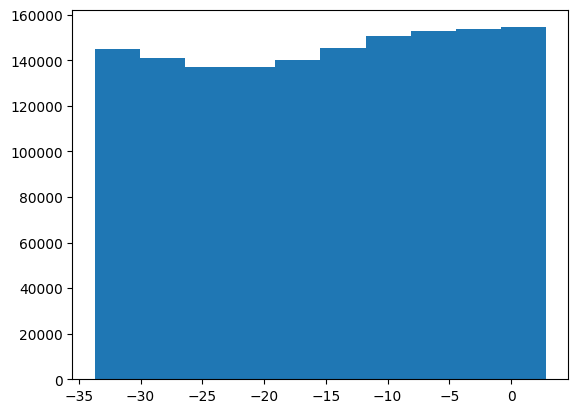

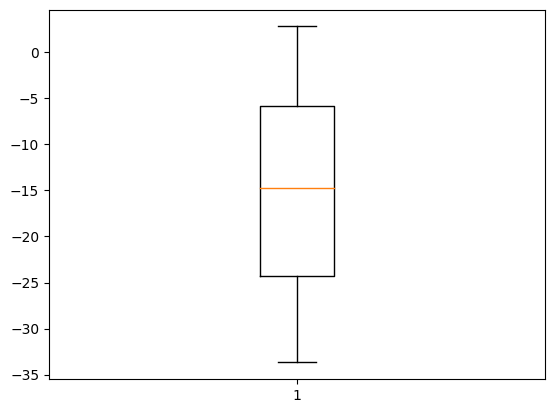

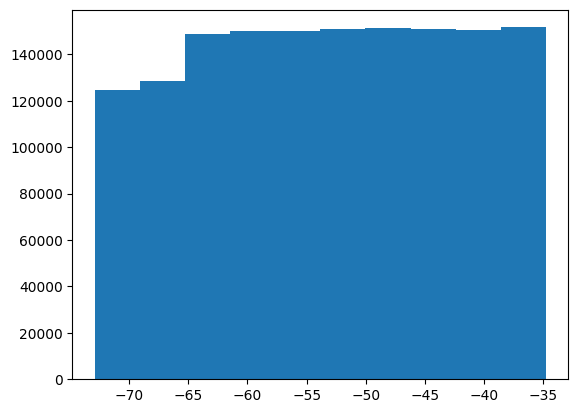

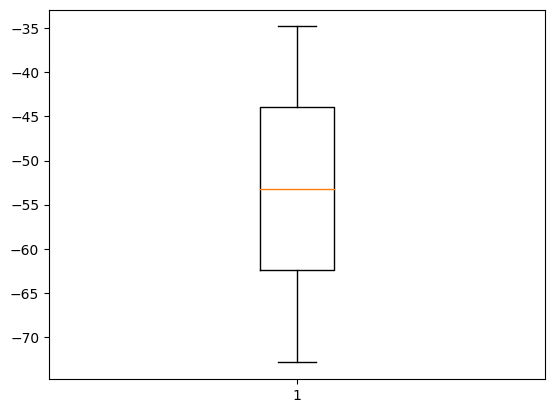

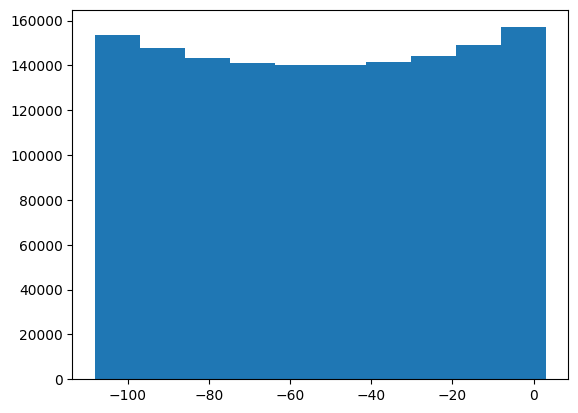

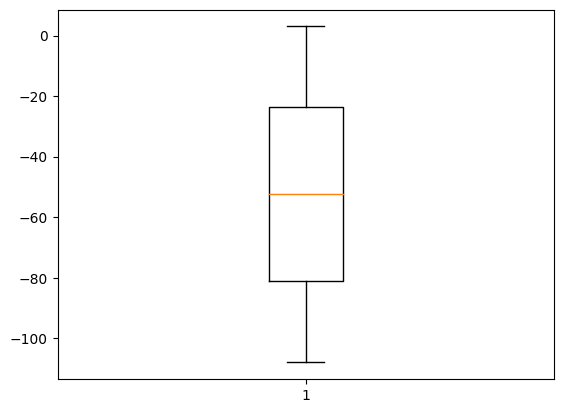

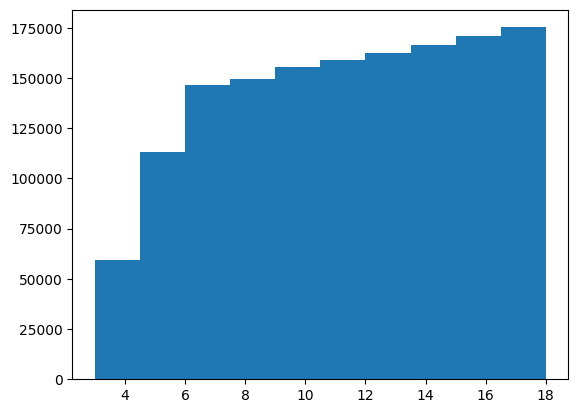

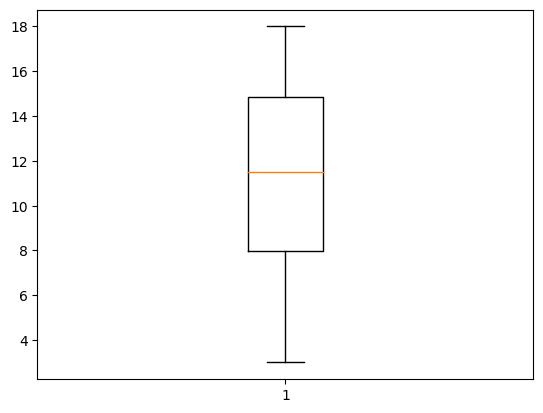

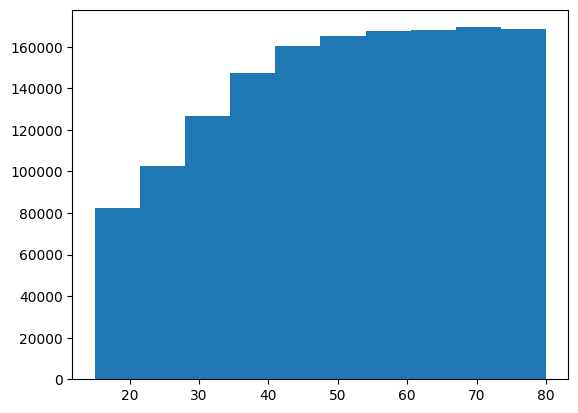

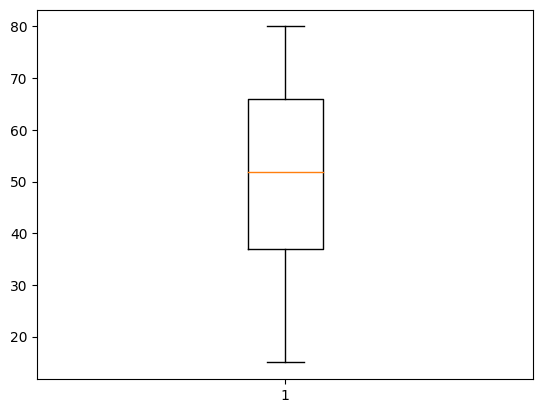

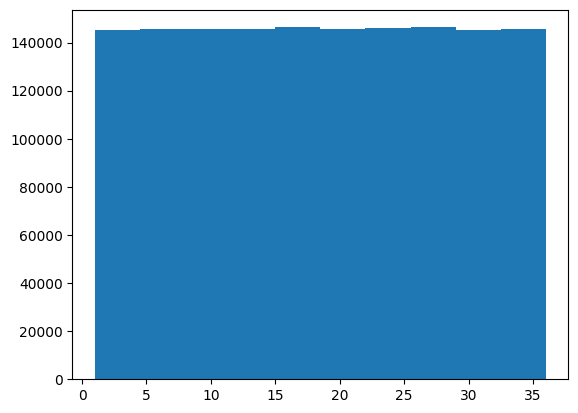

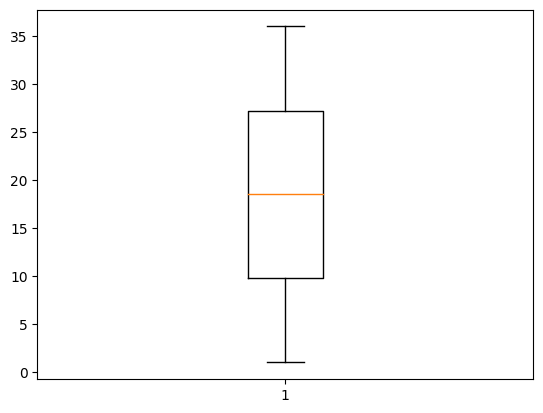

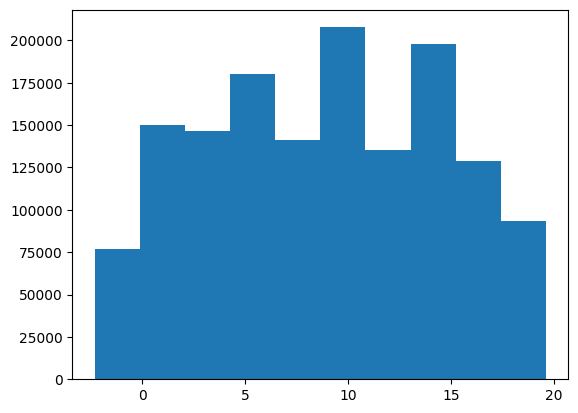

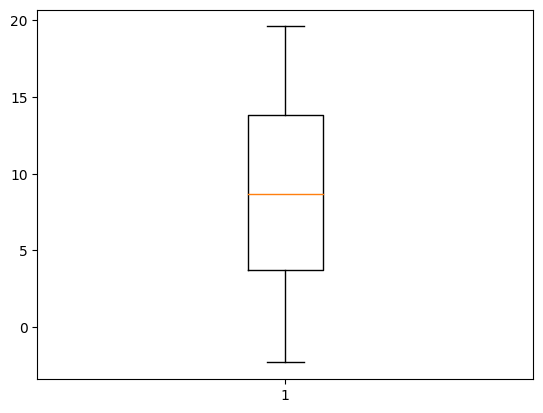

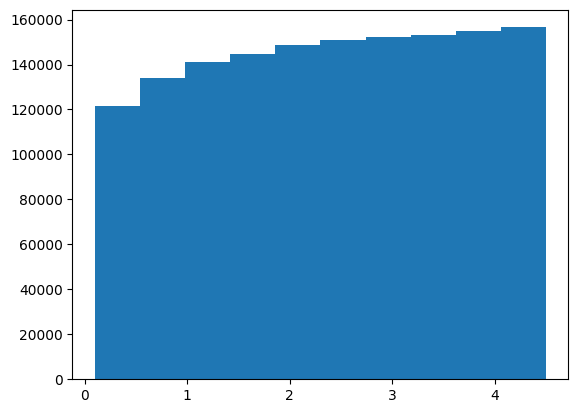

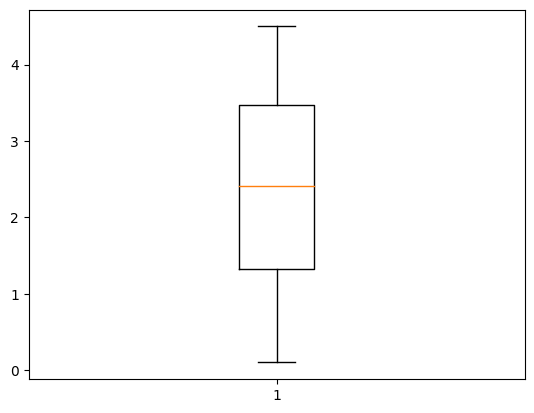

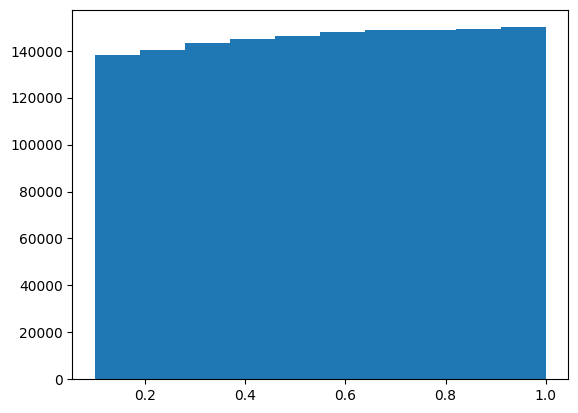

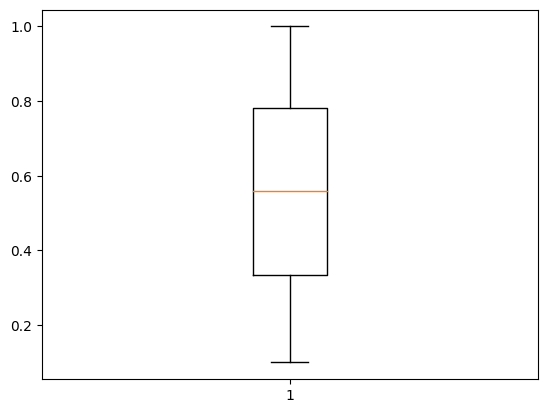

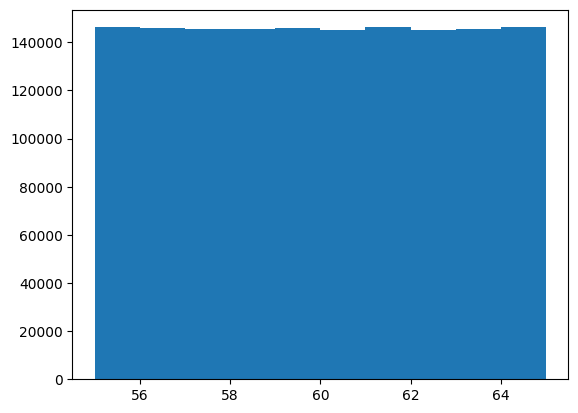

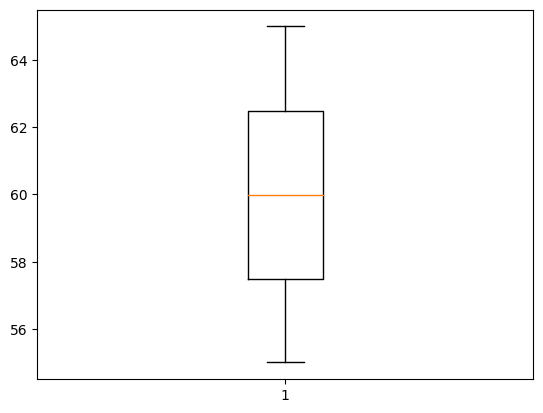

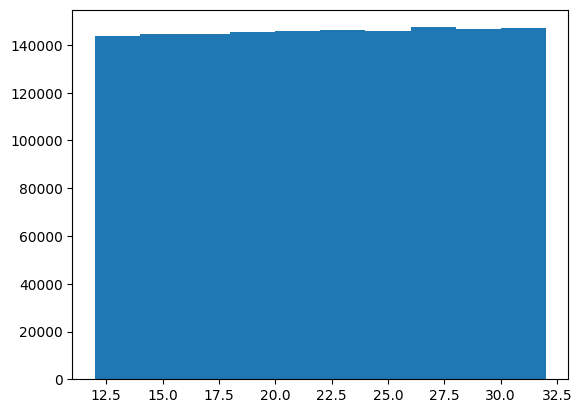

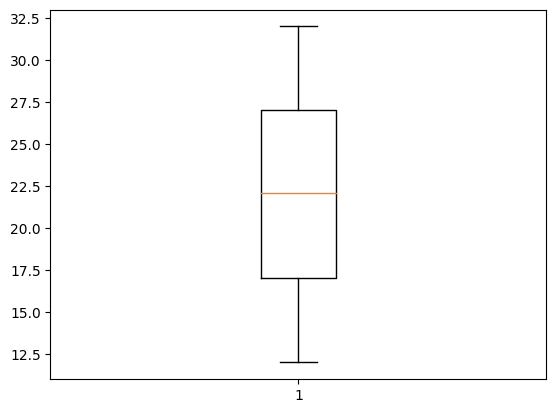

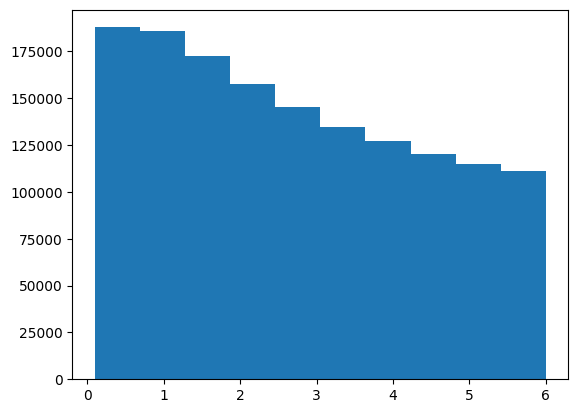

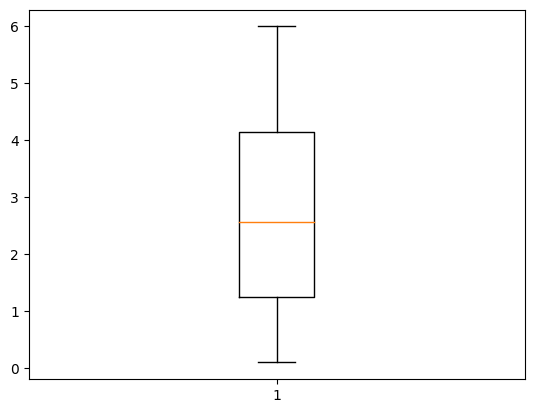

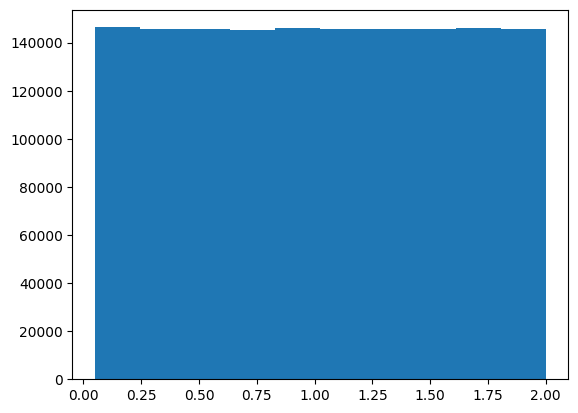

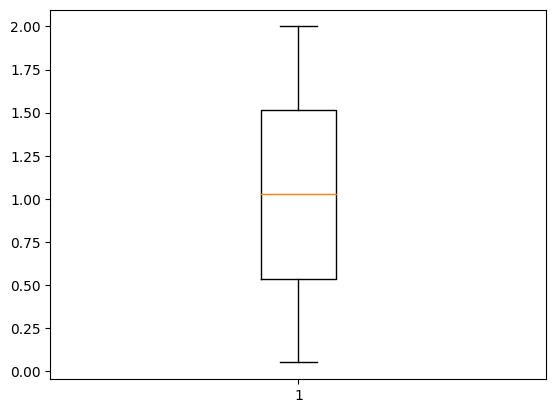

In [10]:
print(filtered_inputs.describe())
for column in inputs.columns:
    # Creating plot
    plt.hist(filtered_inputs[column])
    plt.show()
    plt.boxplot(filtered_inputs[column])
    plt.show()

In [11]:
df = filtered_inputs.assign(availability=filtered_results["availability"])
df.head()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint,availability
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,16.155547,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839,99.904
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,22.226415,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518,99.999
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,14.203504,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404,99.999
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,9.488156,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052,99.990
5,-17.303467,-41.668725,-66.343144,12.480028,27.720772,31.814645,8.326742,4.452849,0.583401,64.208048,17.289375,2.862834,1.010339,99.554


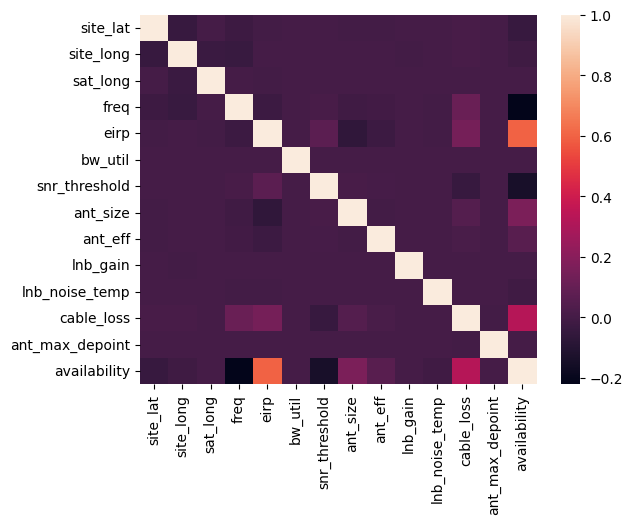

In [12]:
sns.heatmap(df.corr())
plt.show()

In [13]:
df_majority_data = df[df['availability'] >= 99.5]
df_minority_data = df[df['availability'] < 99.5]

In [14]:
df_minority_data.count()

site_lat           333973
site_long          333973
sat_long           333973
freq               333973
eirp               333973
bw_util            333973
snr_threshold      333973
ant_size           333973
ant_eff            333973
lnb_gain           333973
lnb_noise_temp     333973
cable_loss         333973
ant_max_depoint    333973
availability       333973
dtype: int64

In [15]:
df_data_undersample = df_majority_data.sample(int(df_minority_data['availability'].count()/2))

In [16]:
df_balanced = pd.concat([df_data_undersample, df_minority_data], axis=0)
print(df_balanced.head())
df_balanced.describe()

         site_lat  site_long   sat_long       freq       eirp    bw_util  \
755112 -26.365016 -43.619345  -1.285826   7.717572  65.285388   1.670578   
896211  -2.918818 -63.293931 -77.716624  14.433864  75.226808  14.914490   
453288  -6.340118 -63.245557 -91.366891   6.626259  51.869690   8.671269   
474726 -11.800446 -59.841428 -48.526793   7.262472  75.310263  28.067338   
657284 -16.284418 -63.724046 -41.553189  16.067996  72.074094  18.975747   

        snr_threshold  ant_size   ant_eff   lnb_gain  lnb_noise_temp  \
755112       9.605005  1.184043  0.947578  57.659681       20.200012   
896211       7.230340  2.440434  0.946841  57.551836       28.766834   
453288      -0.983941  2.310843  0.285166  62.161726       25.081490   
474726       7.821984  0.623640  0.571186  62.815313       26.893620   
657284       1.215627  3.465418  0.311289  60.985935       14.628528   

        cable_loss  ant_max_depoint  availability  
755112    1.509713         0.200998        99.999  
896211

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint,availability
count,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000
mean,-14.436058,-53.080269,-52.330287,12.376858,40.027679,18.499512,9.590785,2.189365,0.542011,59.999500,22.090704,2.230460,1.025771,98.018378
std,10.654775,10.693470,33.572775,3.944338,17.187774,10.096786,5.801268,1.280324,0.260560,2.890248,5.772441,1.586019,0.562955,1.735493
min,-33.689911,-72.889982,-107.999154,3.000079,15.000334,1.000017,-2.297824,0.100003,0.100003,55.000006,12.000017,0.100010,0.050018,95.000000
25%,-23.704747,-62.016781,-82.636287,9.431209,26.067421,9.754303,5.134135,1.061243,0.314987,57.497545,17.106030,0.890653,0.538170,96.350000
50%,-13.655658,-52.883639,-52.279089,13.040119,36.703485,18.503355,9.605005,2.137128,0.538255,59.998567,22.139719,1.874439,1.025618,98.276000
75%,-5.063537,-43.878273,-21.999465,15.770727,51.552385,27.232866,14.211092,3.288955,0.766483,62.503744,27.097250,3.343256,1.513995,99.976000
max,2.819986,-34.800075,2.999885,17.999990,79.999936,35.999969,19.590329,4.499994,0.999999,64.999992,31.999929,5.999989,1.999997,99.999000


In [17]:
x = df_balanced.drop('availability',axis='columns')
y = df_balanced['availability']

In [18]:
# setando a semente para divisão dos conjuntos de treino e teste
np.random.seed(0)

In [19]:
# separando os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [20]:
# alguns dados estatisticos por atributo
x_train.describe()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
count,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000
mean,-14.454894,-53.078927,-52.309894,12.381430,40.024976,18.487722,9.589735,2.189146,0.542176,59.999207,22.087085,2.231786,1.025619
std,10.660706,10.698323,33.563423,3.944817,17.195990,10.092397,5.800262,1.280372,0.260550,2.891304,5.773674,1.586266,0.563193
min,-33.689833,-72.889982,-107.999154,3.000079,15.000334,1.000017,-2.297824,0.100003,0.100003,55.000006,12.000127,0.100010,0.050020
25%,-23.731285,-62.021324,-82.592380,9.439626,26.060027,9.748034,5.134135,1.062245,0.315133,57.495296,17.097912,0.892000,0.537452
50%,-13.682716,-52.882984,-52.265276,13.046118,36.697429,18.488854,9.605005,2.136892,0.538511,60.000775,22.136409,1.876626,1.026044
75%,-5.077281,-43.867908,-22.017804,15.775799,51.550759,27.217641,14.211092,3.287399,0.766816,62.504822,27.095295,3.344243,1.514184
max,2.819986,-34.800075,2.999885,17.999983,79.999936,35.999969,19.590329,4.499994,0.999999,64.999992,31.999929,5.999989,1.999997


In [21]:
y_train.describe()

count    400767.000000
mean         98.018716
std           1.735148
min          95.000000
25%          96.350000
50%          98.280000
75%          99.976000
max          99.999000
Name: availability, dtype: float64

(array([ 13831.,  43687.,  61486.,  62960.,   5563.,   8005.,  11354.,
         17201.,  43185., 133495.]),
 array([95.    , 95.4999, 95.9998, 96.4997, 96.9996, 97.4995, 97.9994,
        98.4993, 98.9992, 99.4991, 99.999 ]),
 <BarContainer object of 10 artists>)

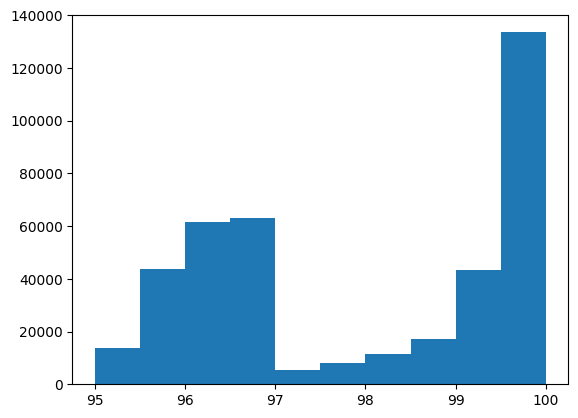

In [22]:
plt.hist(y_train)

In [23]:
y_test.describe()

count    100192.000000
mean         98.017025
std           1.736877
min          95.000000
25%          96.340000
50%          98.221000
75%          99.977000
max          99.999000
Name: availability, dtype: float64

(array([ 3520., 11091., 15085., 15827.,  1373.,  2093.,  2823.,  4213.,
        10676., 33491.]),
 array([95.    , 95.4999, 95.9998, 96.4997, 96.9996, 97.4995, 97.9994,
        98.4993, 98.9992, 99.4991, 99.999 ]),
 <BarContainer object of 10 artists>)

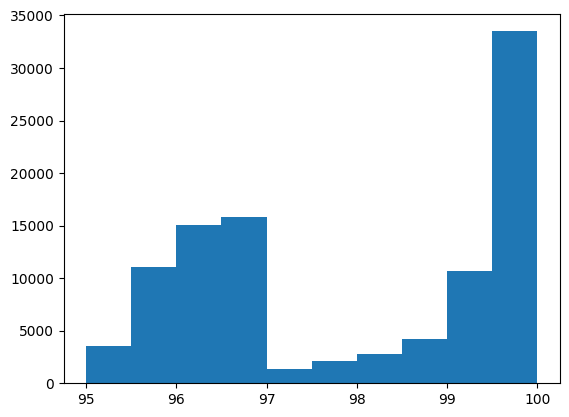

In [24]:
plt.hist(y_test)

In [25]:
# normalização dos dados
preprocessParams = preprocessing.StandardScaler().fit(x_train)
x_train_normalized = preprocessParams.transform(x_train)
x_test_normalized = preprocessParams.transform(x_test)

In [26]:
# y_train_num = pd.to_numeric(y_train)
# y_train_df = pd.DataFrame(y_train_num)
# y_test_num = pd.to_numeric(y_test)
# y_test_df = pd.DataFrame(y_test_num)

# preprocessParamsY = preprocessing.StandardScaler().fit(y_train_df)
# y_train_normalized = preprocessParamsY.transform(y_train_df)
# y_test_normalized = preprocessParamsY.transform(y_test_df)

In [27]:
y_train_normalized = np.log10(y_train)
y_test_normalized = np.log10(y_test)

(array([ 13484.,  41625.,  61443.,  61296.,   8806.,   8064.,  10704.,
         17188.,  43158., 134999.]),
 array([1.97772361, 1.97995081, 1.98217802, 1.98440522, 1.98663243,
        1.98885963, 1.99108684, 1.99331404, 1.99554125, 1.99776845,
        1.99999566]),
 <BarContainer object of 10 artists>)

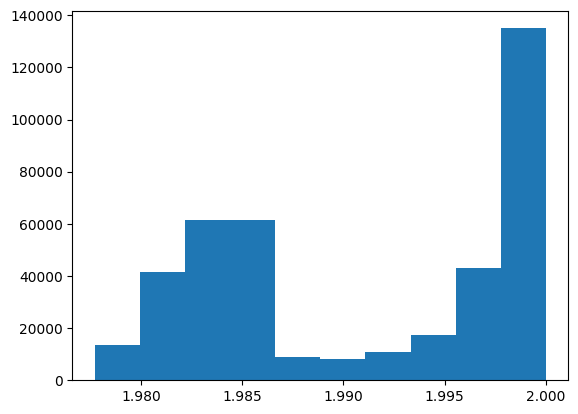

In [28]:
plt.hist(y_train_normalized)

(array([ 3434., 10569., 15092., 15373.,  2224.,  2073.,  2668.,  4234.,
        10690., 33835.]),
 array([1.97772361, 1.97995081, 1.98217802, 1.98440522, 1.98663243,
        1.98885963, 1.99108684, 1.99331404, 1.99554125, 1.99776845,
        1.99999566]),
 <BarContainer object of 10 artists>)

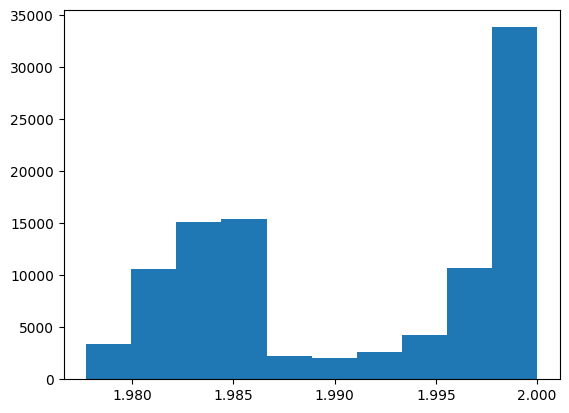

In [29]:
plt.hist(y_test_normalized)

In [30]:
x_train_normalized.shape[1:]

(13,)

In [31]:
# teste de rede neural
RN = Sequential()
RN.add(Dense(256, input_shape = x_train_normalized.shape[1:], activation = 'sigmoid'))
RN.add(Dropout(0.05))
RN.add(Dense(128, activation = 'sigmoid'))
RN.add(Dropout(0.05))
RN.add(Dense(1))
RN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36609 (143.00 KB)
Trainable params: 36609 (143.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# treinamento
RN.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mape', 'mae', 'msle', 'log_cosh', 'cosine_proximity']) 
history = RN.fit(x_train_normalized, y_train_normalized, epochs=200, validation_split=0.2)

Epoch 1/200
10020/10020 [==============================] - 8s 732us/step - loss: 4.4271e-06 - mape: 0.0736 - mae: 0.0015 - msle: 4.9609e-07 - log_cosh: 2.2116e-06 - cosine_proximity: 1.0000 - val_loss: 4.1819e-06 - val_mape: 0.0677 - val_mae: 0.0013 - val_msle: 4.6896e-07 - val_log_cosh: 2.0889e-06 - val_cosine_proximity: 1.0000
Epoch 2/200
10020/10020 [==============================] - 7s 727us/step - loss: 4.4257e-06 - mape: 0.0737 - mae: 0.0015 - msle: 4.9593e-07 - log_cosh: 2.2109e-06 - cosine_proximity: 1.0000 - val_loss: 3.8940e-06 - val_mape: 0.0640 - val_mae: 0.0013 - val_msle: 4.3662e-07 - val_log_cosh: 1.9449e-06 - val_cosine_proximity: 1.0000
Epoch 3/200
10020/10020 [==============================] - 7s 728us/step - loss: 4.4119e-06 - mape: 0.0735 - mae: 0.0015 - msle: 4.9439e-07 - log_cosh: 2.2040e-06 - cosine_proximity: 1.0000 - val_loss: 4.4795e-06 - val_mape: 0.0694 - val_mae: 0.0014 - val_msle: 5.0246e-07 - val_log_cosh: 2.2376e-06 - val_cosine_proximity: 1.0000
Epoch 4

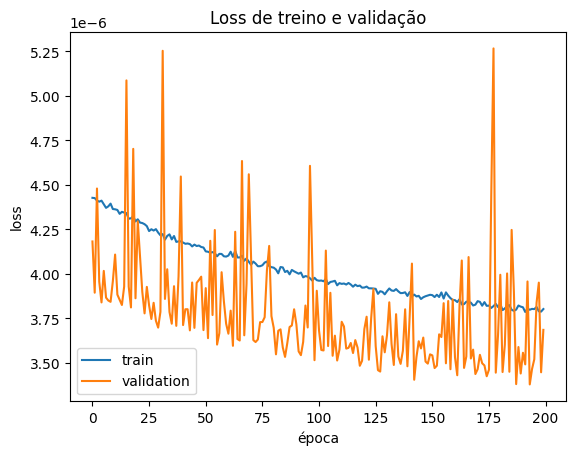

In [34]:
# gráfico do treinamento: custo do treino e validação
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss de treino e validação')
plt.ylabel('loss')
plt.xlabel('época')
plt.legend();

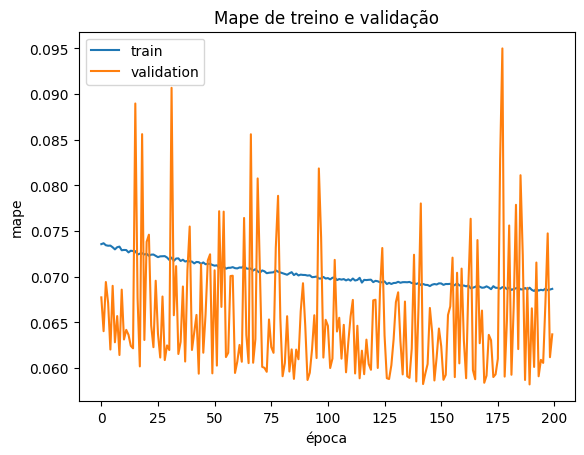

In [35]:
# gráfico do treinamento: mape do treino e validação
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='validation')
plt.title('Mape de treino e validação')
plt.ylabel('mape')
plt.xlabel('época')
plt.legend();

In [36]:
# avaliação
score = RN.evaluate(x_train_normalized, y_train_normalized, verbose = 0)
print('Train score:', score[0])
print('Train mape:', score[1], '%')

Train score: 3.558267280823202e-06
Train mape: 0.06302177160978317 %


In [37]:
# avaliação
score = RN.evaluate(x_test_normalized, y_test_normalized, verbose = 0)
print('Test score:', score[0])
print('Test mape:', score[1], '%')

Test score: 3.6779260881303344e-06
Test mape: 0.06375325471162796 %


12524/12524 [==============================] - 4s 279us/step


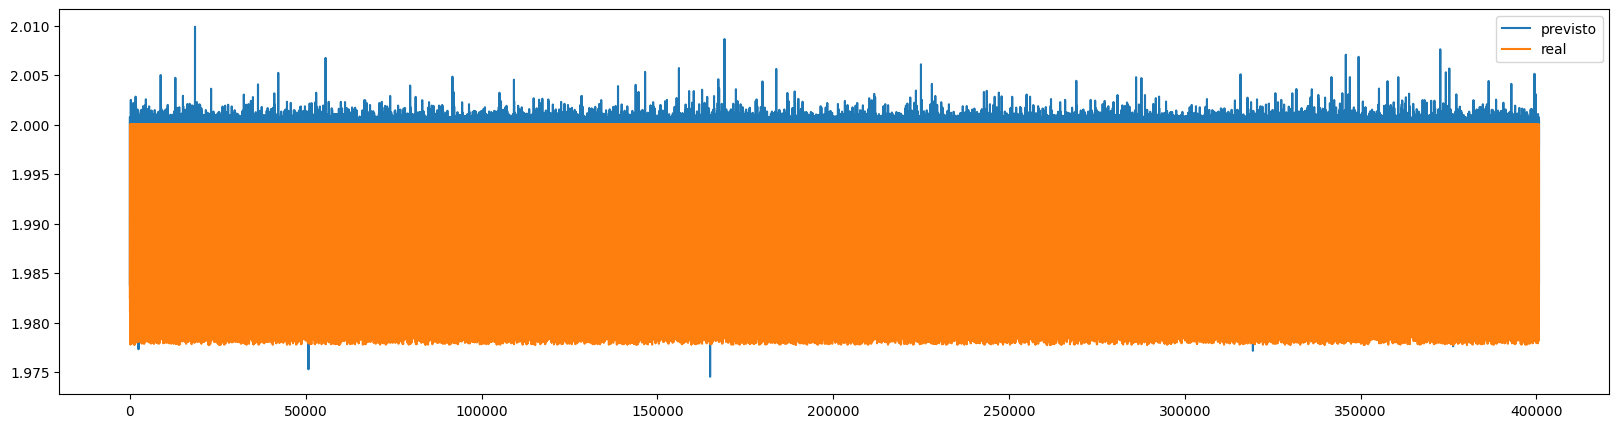

In [38]:
# avaliação gráfica
y_train_predicted = RN.predict(x_train_normalized)

results_train = pd.DataFrame(y_train_predicted, columns = ['previsto'])
results_train['real'] = np.array(y_train_normalized)
results_train.plot(figsize=(20,5)); # todas as previsões

3131/3131 [==============================] - 1s 305us/step


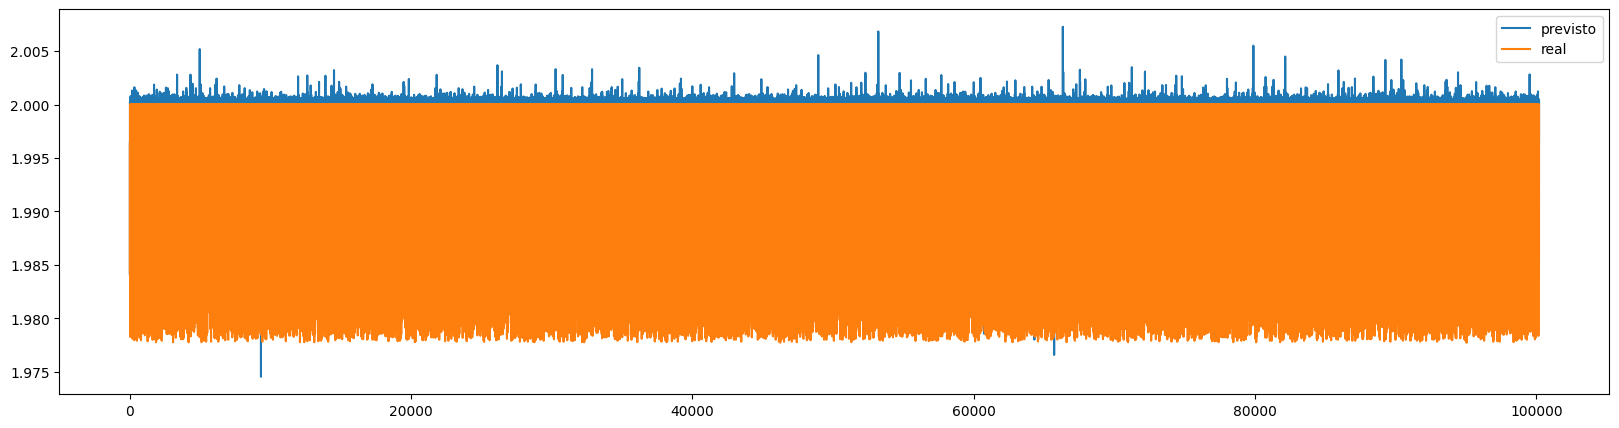

In [39]:
# avaliação gráfica
y_test_predicted = RN.predict(x_test_normalized)

results = pd.DataFrame(y_test_predicted, columns = ['previsto'])
results['real'] = np.array(y_test_normalized)
results.plot(figsize=(20,5)); # todas as previsões

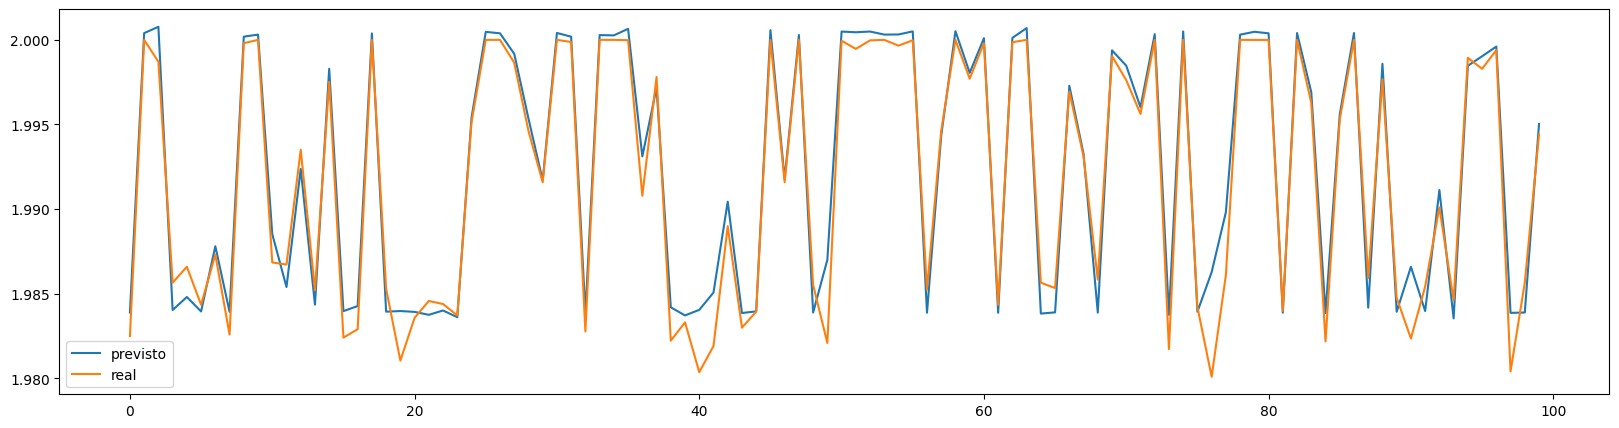

In [40]:
results_train.iloc[0:100,:].plot(figsize=(20,5)); # somente as 100 primeiras

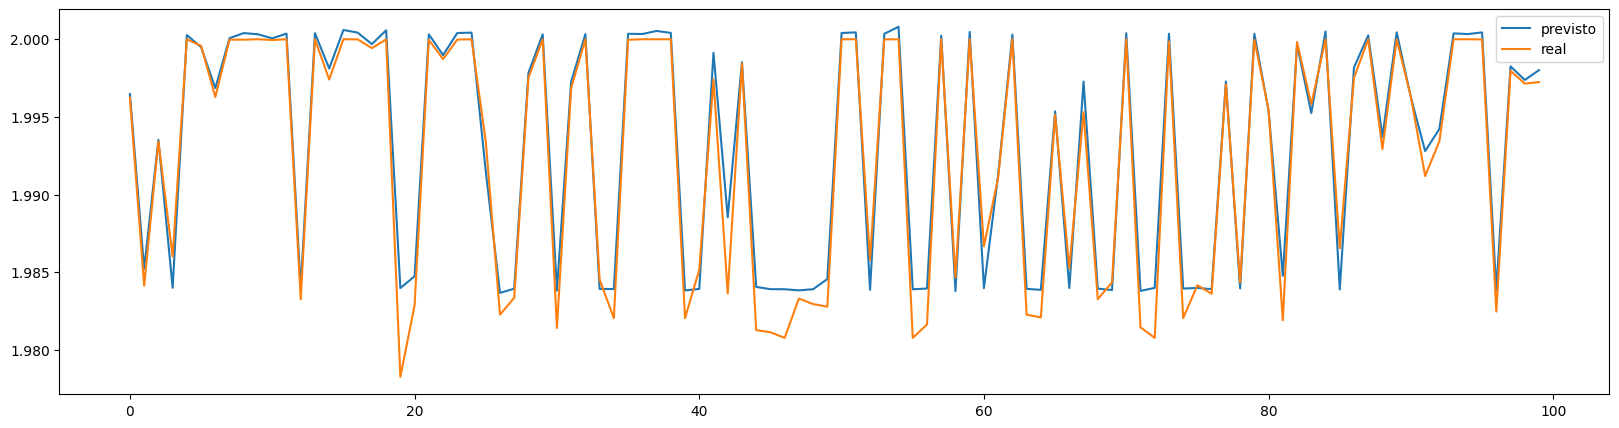

In [41]:
results.iloc[0:100,:].plot(figsize=(20,5)); # somente as 100 primeiras

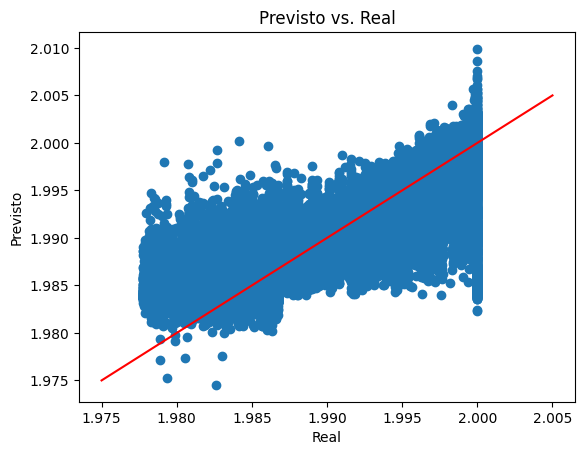

In [42]:
plt.scatter(x=y_train_normalized, y=y_train_predicted)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [1.975, 2.005]
plt.plot(x, x, color='red'); # reta onde y=x

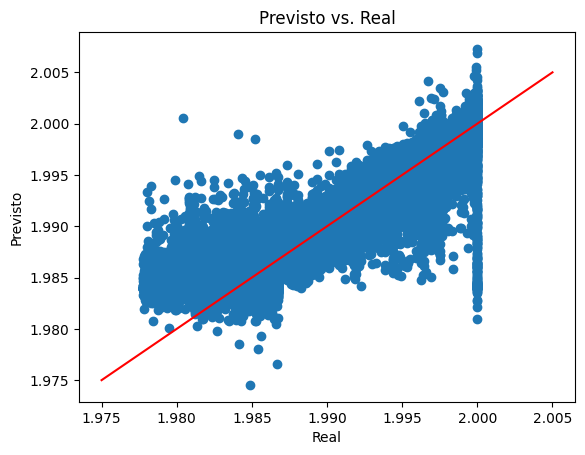

In [43]:
plt.scatter(x=y_test_normalized, y=y_test_predicted)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [1.975, 2.005]
plt.plot(x, x, color='red'); # reta onde y=x

In [44]:
r2_score(y_train_normalized, y_train_predicted)

0.9399029794116291

In [45]:
r2_score(y_test_normalized, y_test_predicted)

0.938006493662018

In [46]:
#desnormalizando e checando os valores de novo:
y_train_predicted_denorm = 10**y_train_predicted
y_test_predicted_denorm = 10**y_test_predicted

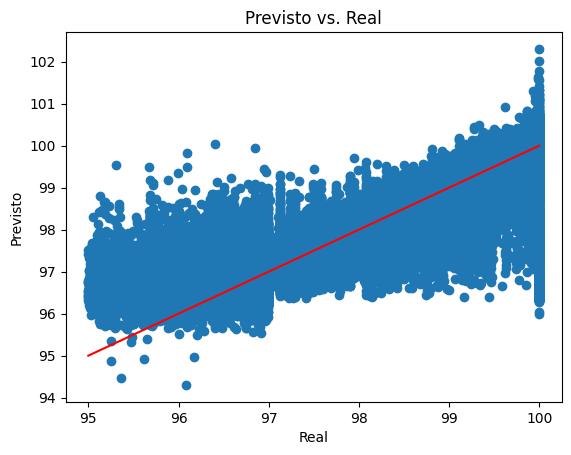

In [47]:
plt.scatter(x=y_train, y=y_train_predicted_denorm)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [95, 100]
plt.plot(x, x, color='red'); # reta onde y=x

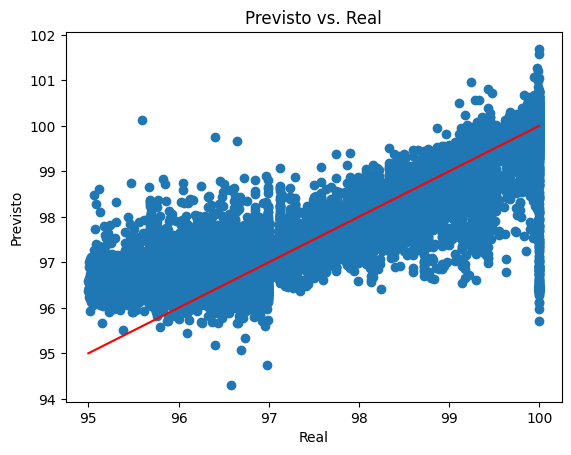

In [48]:
plt.scatter(x=y_test, y=y_test_predicted_denorm)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [95, 100]
plt.plot(x, x, color='red'); # reta onde y=x

In [49]:
r2_score(y_train, y_train_predicted_denorm)

0.9413641460661565

In [50]:
r2_score(y_test, y_test_predicted_denorm)

0.939483065527838